<a href="https://colab.research.google.com/github/binhvd/Data-Analytics-3-Labs/blob/main/12_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
%cd /content/gdrive/My\ Drive/GAN/

/content/gdrive/My Drive/GAN


In [5]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential

In [6]:
def generator_for_images():

    generator = Sequential()

    generator.add(Dense(256*4*4, input_shape = (100,)))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((4,4,256)))

    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))


    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generator.add(BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generator)


In [7]:
model_generator = generator_for_images()
model_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                              

1/1 [==============================] - 0s 16ms/step


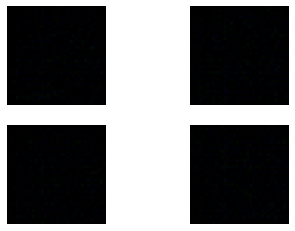

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define input data
def generate_input_data(n_samples):
  X = np.random.randn(100 * n_samples)
  X = X.reshape(n_samples, 100)
  return X

def create_data_fake(model_generator, n_samples):
  input = generate_input_data(n_samples)
  X = model_generator.predict(input)
  y = np.zeros((n_samples, 1))
  return X,y

number_samples = 4
X,_ = create_data_fake(model_generator, number_samples)

# We visualize results
for i in range(number_samples):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

In [9]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

def image_discriminator():

    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=3, padding = "same", input_shape= (32,32,3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128,kernel_size=3,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128,kernel_size=3,strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    #discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002,beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer= opt , metrics= ['accuracy'])

    return (discriminator)

In [10]:
model_discriminator = image_discriminator()
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
from keras.datasets import cifar10

def load_images():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # We normalize the data
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

In [13]:
print(load_images().shape)

170498071/170498071 [==============================] - 13s 0us/step
(5000, 32, 32, 3)


In [14]:
import random

def upload_real_data(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

def upload_fake_data(n_samples):
  X = np.random.rand(32 * 32 * 3 * n_samples)
  X = -1 + X * 2
  X = X.reshape((n_samples, 32,32,3))
  y = np.zeros((n_samples, 1))
  return X,y

In [15]:
def training_discriminator(model, dataset, n_iteration=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteration):
    X_real, y_real = upload_real_data(dataset, medio_batch)
    _, acc_real = model.train_on_batch(X_real, y_real)

    X_fake, y_fake = upload_fake_data(medio_batch)
    _, acc_fake = model.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [16]:
dataset = load_images()
training_discriminator(model_discriminator, dataset)

1 Real:23.4375, Fake:18.75
2 Real:92.1875, Fake:56.25
3 Real:87.5, Fake:76.5625
4 Real:79.6875, Fake:93.75
5 Real:78.125, Fake:100.0
6 Real:78.125, Fake:100.0
7 Real:84.375, Fake:100.0
8 Real:81.25, Fake:100.0
9 Real:67.1875, Fake:100.0
10 Real:73.4375, Fake:100.0
11 Real:87.5, Fake:100.0
12 Real:70.3125, Fake:100.0
13 Real:92.1875, Fake:100.0
14 Real:92.1875, Fake:100.0
15 Real:96.875, Fake:100.0
16 Real:96.875, Fake:100.0
17 Real:98.4375, Fake:100.0
18 Real:98.4375, Fake:100.0
19 Real:98.4375, Fake:100.0
20 Real:100.0, Fake:100.0


In [17]:
def create_gan(discriminator, generator):
  discriminator.trainable=False
  gan = Sequential()
  gan.add (generator)
  gan.add (discriminator)

  opt = Adam(lr=0.0002,beta_1=0.5)
  gan.compile(loss = "binary_crossentropy", optimizer = opt)

  return gan

In [18]:
gan = create_gan(model_discriminator,model_generator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         1007363   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def show_generated_images(data_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # We make the data go from 0 to 1
  data_fake = (data_fake + 1) / 2.0

  for i in range(10):
    plt.imshow (data_fake[i])
    plt.axis ("off")
    name = str (epoch) + '_generate_image_' + str(i)+'.png'
    plt.savefig (name, bbox_inches= 'tight')
    plt.close()

In [24]:
def evaluate_and_save(model_generator, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  name = str(epoch) + '_' + str(now)+"_generator_model_" + '.h5'
  model_generator.save(name)

  # We generate new data
  X_real,Y_real = upload_real_data(dataset, medio_dataset)
  X_fake, Y_fake = create_data_fake(model_generator,medio_dataset)

  # We evaluate the model
  _, acc_real = model_discriminator.evaluate(X_real, Y_real)
  _, acc_fake = model_discriminator.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [25]:
def training(data, model_generator, model_discriminator, epochs, n_batch, start = 0):
  dimension_batch = int(data.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(start, start + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = upload_real_data(dataset, medio_dataset)


      # We train the discriminator withEnrenamos discriminator with real data
      cost_discriminator_real, _ = model_discriminator.train_on_batch(X_real, Y_real)
      X_fake, Y_fake = create_data_fake(model_generator,medio_dataset)

      cost_discriminator_fake, _ = model_discriminator.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generate_input_data(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
      evaluate_and_save(model_generator,epoch = epoch, medio_dataset= medio_dataset)
      show_generated_images(X_fake, epoch = epoch)

In [ ]:
training(dataset, model_generator, model_discriminator, epochs = 300, n_batch=128, start = 0)

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step - loss: 0.3539 - accuracy: 0.9688
Acc Real:46.875% Acc Fake:96.875%
2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step - loss: 0.4424 - accuracy: 0.8906
Acc Real:64.0625% Acc Fake:89.0625%
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step - loss: 0.4891 - accuracy: 0.8906
Acc Real:68.75% Acc Fake:89.0625%
2/2 [==============================] - 0s 5ms/step


In [ ]:
X_fake, _ = create_data_fake(n_muestras=49, modelo_generador=model_generator)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])